# Model for Forecasting using PID Control Data 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import os
import torch
import torch.nn as nn

In [3]:
cpu_temp = pd.read_csv("../data/pid_2/cpu_temp.csv", header=None, names=["time", "cpu_temp"])
fan_speed = pd.read_csv("../data/pid_2/fan_speed.csv", header=None, names=["time", "fan_speed"])
it_power = pd.read_csv("../data/pid_2/cpu_power.csv", header=None, names=["time", "it_power"])

In [4]:
def process_dataframe(df, time_col, value_col):
    df[time_col] = df[time_col].astype(int)

    min_time = df[time_col].min()
    max_time = df[time_col].max()
    full_index = pd.DataFrame({time_col: np.arange(min_time, max_time + 1)})

    df_full = pd.merge(full_index, df, on=time_col, how='left')
    df_full[value_col] = df_full[value_col].interpolate(method="polynomial", order=2)

    return df_full

cpu_temp_new = process_dataframe(cpu_temp, "time", "cpu_temp")
fan_speed_new = process_dataframe(fan_speed, "time", "fan_speed")
it_power_new = process_dataframe(it_power, "time", "it_power")

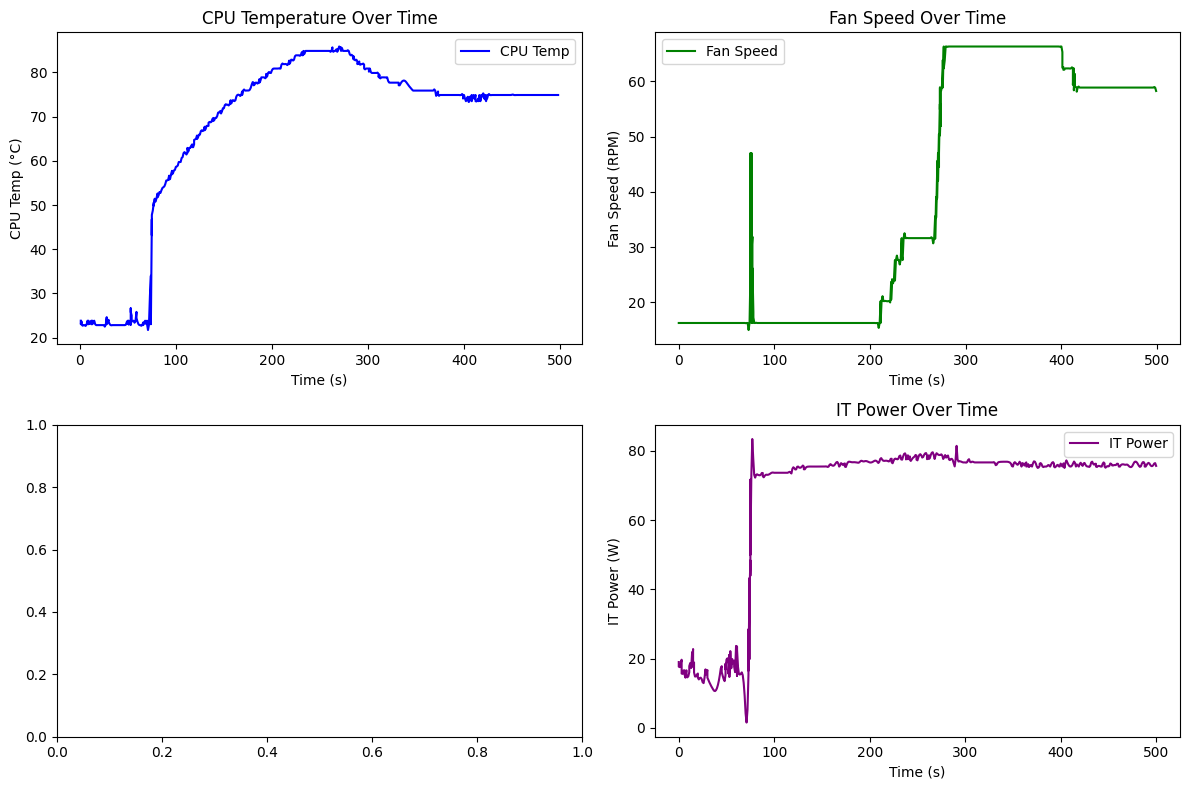

In [5]:
def plot_time_series_subplots(cpu_temp_df, fan_speed_df, it_power_df, time_col):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # First subplot - CPU Temperature
    axs[0, 0].plot(cpu_temp_df[time_col], cpu_temp_df['cpu_temp'], color='blue', label='CPU Temp')
    axs[0, 0].set_title('CPU Temperature Over Time')
    axs[0, 0].set_xlabel('Time (s)')
    axs[0, 0].set_ylabel('CPU Temp (°C)')
    axs[0, 0].legend()

    # Second subplot - Fan Speed
    axs[0, 1].plot(fan_speed_df[time_col], fan_speed_df['fan_speed'], color='green', label='Fan Speed')
    axs[0, 1].set_title('Fan Speed Over Time')
    axs[0, 1].set_xlabel('Time (s)')
    axs[0, 1].set_ylabel('Fan Speed (RPM)')
    axs[0, 1].legend()

    # Fourth subplot - IT Power
    axs[1, 1].plot(it_power_df[time_col], it_power_df['it_power'], color='purple', label='IT Power')
    axs[1, 1].set_title('IT Power Over Time')
    axs[1, 1].set_xlabel('Time (s)')
    axs[1, 1].set_ylabel('IT Power (W)')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


plot_time_series_subplots(cpu_temp_new, fan_speed_new, it_power_new, time_col="time")

In [6]:
max_start = max(cpu_temp_new['time'].min(), it_power_new['time'].min(), fan_speed_new['time'].min())
min_end = min(cpu_temp_new['time'].max(), it_power_new['time'].max(), fan_speed_new['time'].max())

cpu_temp_filtered = cpu_temp_new[(cpu_temp_new['time'] >= max_start) & (cpu_temp_new['time'] <= min_end)]
it_power_filtered = it_power_new[(it_power_new['time'] >= max_start) & (it_power_new['time'] <= min_end)]
fan_speed_filtered = fan_speed_new[(fan_speed_new['time'] >= max_start) & (fan_speed_new['time'] <= min_end)]

combined_df = pd.merge(cpu_temp_filtered, it_power_filtered, on='time')
combined_df = pd.merge(combined_df, fan_speed_filtered, on='time')

combined_df.head()

,time,cpu_temp,it_power,fan_speed
0,1,23.843226,17.510604,16.286095
1,1,23.045820,17.510604,16.286095
2,2,23.643874,18.460736,16.286095
3,2,22.946144,18.460736,16.286095
4,3,22.715386,19.656845,16.286095


In [7]:
df = combined_df.copy()
print(f"Shape of Final Dataframe = {df.shape}")

Shape of Final Dataframe = (5187, 4)


In [8]:
scalers = {
    'cpu_temp': MinMaxScaler(),
    'it_power': MinMaxScaler(),
    'fan_speed': MinMaxScaler()
}

df_scaled = pd.DataFrame(index=df.index)

for col, scaler in scalers.items():
    df_scaled[col] = scaler.fit_transform(df[[col]]).ravel()

In [9]:
df_scaled.head()

,cpu_temp,it_power,fan_speed
0,0.032956,0.195323,0.024895
1,0.020518,0.195323,0.024895
2,0.029846,0.206920,0.024895
3,0.018963,0.206920,0.024895
4,0.015364,0.221519,0.024895


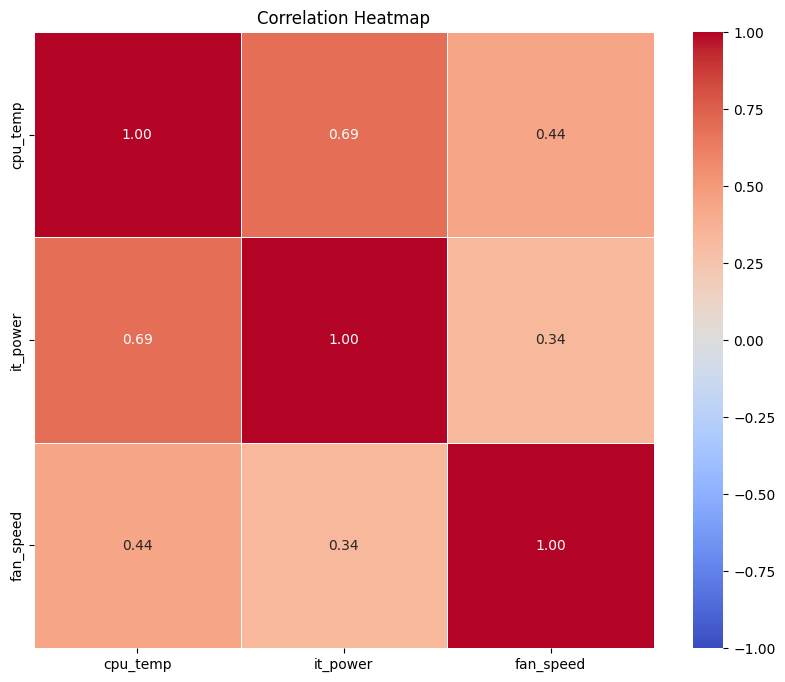

In [10]:
cols = ["cpu_temp", "it_power", "fan_speed"]

corr = df[cols].corr()

plt.figure(figsize=(10, 8)) 
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## Modeling

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out


In [12]:
class MultiStepForecaster:
    def __init__(self, data, window_size, pred_horizon, target_col, hidden_size=64, num_layers=2, batch_size=32, learning_rate=0.001, num_epochs=100, method="recursive"):
        self.data = data
        self.window_size = window_size
        self.pred_horizon = pred_horizon
        self.target_col = target_col

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

        self.model = None
        self.criterion = None
        self.optimizer = None

        self.method = method

    def prepare_recursive_data(self):
        X, y = [], []

        for i in range(len(self.data) - self.window_size - 1):
            X.append(self.data[i:i + self.window_size])
            y.append(self.data[i + self.window_size, self.target_col])

        X = np.array(X)
        y = np.array(y)

        return X, y

    def prepare_multi_output_data(self):
        X, y = [], []

        for i in range(len(self.data) - self.window_size - self.pred_horizon):
            X.append(self.data[i:i + self.window_size])
            y.append(self.data[i + self.window_size:i + self.window_size + self.pred_horizon, self.target_col])

        X = np.array(X)
        y = np.array(y)

        return X, y

    def prepare_data(self):

        if self.method == "recursive":
            X, y = self.prepare_recursive_data()
        elif self.method == "multi-output":
            X, y = self.prepare_multi_output_data()

        return X, y
    
    def train_test_split(self, X, y, test_size=0.2):
        split_idx = int(len(X) * (1 - test_size))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        return X_train, X_test, y_train, y_test
    
    def build_model(self):

        input_size = self.data.shape[1] 
        output_size = 1 if self.method == "recursive" else self.pred_horizon

        self.model = LSTMModel(input_size, self.hidden_size, self.num_layers, output_size)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def train_model(self, X_train, y_train):
        self.model.train()

        for epoch in range(self.num_epochs):
            inputs = torch.tensor(X_train, dtype=torch.float32)
            targets = torch.tensor(y_train, dtype=torch.float32)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)

            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()

            if (epoch+1) % 10 == 0:
                print(f'Epoch {epoch+1} Loss: {loss.item()}')

        if self.method == "recursive":  
            torch.save(self.model.state_dict(), "../models/recursive_model.pth")
        elif self.method == "multi-output":
            torch.save(self.model.state_dict(), "../models/multi_output_model.pth")

    def recursive_forecast(self, X_test):
        self.model.eval()
        recursive_predictions = []
    
        with torch.no_grad():
            for i in range(len(X_test)):
                current_input = X_test[i].astype(np.float32) 
                
                for _ in range(self.pred_horizon):
                    current_input_tensor = torch.tensor(current_input, dtype=torch.float32).unsqueeze(0)
                    prediction = self.model(current_input_tensor).view(-1).item()
                    
                    recursive_predictions.append(prediction)
                    
                    current_input = np.roll(current_input, -1, axis=0)
                    current_input[-1, self.target_col] = prediction

        return np.array(recursive_predictions)

    def multi_output_forecast(self, X_test):
        self.model.eval()
        
        with torch.no_grad():
            inputs = torch.tensor(X_test, dtype=torch.float32)
            y_pred = self.model(inputs).numpy()

        return y_pred

    def evaluate(self, X_test, y_test):
        if self.method == "recursive":
            preds = self.recursive_forecast(X_test)
        elif self.method == "multi-output":
            preds = self.multi_output_forecast(X_test)

        y_test = y_test if len(y_test.shape) == len(preds.shape) else y_test.reshape(preds.shape)
        mse = np.mean((preds - y_test) ** 2)
        r2 = r2_score(y_test, preds)

        print(f"Mean Squared Error: {mse:.4f}")
        print(f"R² Score: {r2:.4f}")

        return mse, r2
       

In [13]:
class Pipeline:
    def __init__(self, data, window_size, pred_horizon, target_col, hidden_size=64, num_layers=2, batch_size=32, learning_rate=0.001, num_epochs=100):
        self.data = data
        self.window_size = window_size
        self.pred_horizon = pred_horizon
        self.target_col = target_col
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

        self.recursive_forecaster = MultiStepForecaster(
            data=self.data,
            window_size=self.window_size,
            pred_horizon=self.pred_horizon,
            target_col=self.target_col,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_size=self.batch_size,
            learning_rate=self.learning_rate,
            num_epochs=self.num_epochs,
            method="recursive"
        )

        self.multi_output_forecaster = MultiStepForecaster(
            data=self.data,
            window_size=self.window_size,
            pred_horizon=self.pred_horizon,
            target_col=self.target_col,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_size=self.batch_size,
            learning_rate=self.learning_rate,
            num_epochs=self.num_epochs,
            method="multi-output"
        )

    def execute_recursive(self):
        # Initialize forecaster with recursive method
        forecaster = self.recursive_forecaster

        # Prepare data
        X, y = forecaster.prepare_data()
        X_train, X_test, y_train, y_test = forecaster.train_test_split(X, y)

        # Build, train, and evaluate the model
        forecaster.build_model()
        forecaster.train_model(X_train, y_train)

        X, y = self.multi_output_forecaster.prepare_data()
        X_train, X_test, y_train, y_test = self.multi_output_forecaster.train_test_split(X, y)
        # print(f"Test size: {y_test.shape}")
        forecaster.evaluate(X_test, y_test)

    def execute_multi_output(self):
        # Initialize forecaster with multi-output method
        forecaster = self.multi_output_forecaster

        # Prepare data
        X, y = forecaster.prepare_data()
        X_train, X_test, y_train, y_test = forecaster.train_test_split(X, y)
        # print(f"Test size: {y_test.shape}")

        # Build, train, and evaluate the model
        forecaster.build_model()
        forecaster.train_model(X_train, y_train)
        mse, r2 = forecaster.evaluate(X_test, y_test)

        return mse, r2


In [18]:
data = df_scaled.to_numpy()
window_size = 30
pred_horizon = 10
target_col = 0

hidden_size = 64
num_layers = 2
batch_size = 64
learning_rate = 0.001
num_epochs = 500

modeling_pipeline = Pipeline(
    data=data,
    window_size=window_size,
    pred_horizon=pred_horizon,
    target_col=target_col,
    hidden_size=hidden_size,
    num_layers=num_layers,
    batch_size=batch_size,
    learning_rate=learning_rate,
    num_epochs=num_epochs
)

In [19]:
print("\nExecuting Multi-Output Forecasting:")
modeling_pipeline.execute_multi_output()


Executing Multi-Output Forecasting:
Epoch 10 Loss: 0.04912686347961426
Epoch 20 Loss: 0.008896702900528908
Epoch 30 Loss: 0.006654386408627033
Epoch 40 Loss: 0.004683515522629023
Epoch 50 Loss: 0.004293681122362614
Epoch 60 Loss: 0.003883242141455412
Epoch 70 Loss: 0.003454103134572506
Epoch 80 Loss: 0.002960857469588518
Epoch 90 Loss: 0.0023038696963340044
Epoch 100 Loss: 0.0016946997493505478
Epoch 110 Loss: 0.0011862963438034058
Epoch 120 Loss: 0.0009610081324353814
Epoch 130 Loss: 0.000841033470351249
Epoch 140 Loss: 0.0007005241932347417
Epoch 150 Loss: 0.0005375918699428439
Epoch 160 Loss: 0.0014714676653966308
Epoch 170 Loss: 0.0007508728886023164
Epoch 180 Loss: 0.0005838414072059095
Epoch 190 Loss: 0.000512810074724257
Epoch 200 Loss: 0.0004667554167099297
Epoch 210 Loss: 0.00045217681326903403
Epoch 220 Loss: 0.0004442242789082229
Epoch 230 Loss: 0.00043700853711925447
Epoch 240 Loss: 0.00043220302904956043
Epoch 250 Loss: 0.0004276866384316236
Epoch 260 Loss: 0.000423501245

(np.float64(0.016501151594617226), 0.7081213806478622)

: 